In [16]:
# 패키지 설치
!pip install konlpy
!pip install wordcloud
!pip install pandas matplotlib

In [17]:
# 한글 폰트 설치 및 확인
!apt-get update -qq
!apt-get install -qq fonts-nanum
!fc-list :lang=ko

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf: NanumBarunGothic,나눔바른고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothic.ttf: NanumGothic,나눔고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf: NanumGothicCoding,나눔고딕코딩:style=Regular
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf: NanumBarunGo

# **1. 데이터 전처리**
* 추출한 텍스트 데이터를 바탕으로 전처리 하는 코드
* 전체 학생 데이터에서 학과, 전형, 생기부 기록을 추출하여 하나의 텍스트 파일을 생성함
* 생성한 텍스트 파일에서 키워드를 추출하여 csv 파일로 저장함

In [18]:
# 생기부 zip 파일 압축 해제
import zipfile
import os

zip_path = "/content/생기부_원본_수정_txt.zip"
extract_path = "/content/records"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['202110491_3학년_경제금융_윤도경_정시_censored.txt',
 '202511291_1_자유전공학부(인문사회계열)_조은진_정시_censored.txt',
 '201910689_4학년_글로벌경영학과_손민수_정시_censored.txt',
 '202410723_2학년_컴퓨터과학과_이정원_수시_censored.txt',
 '202510837_1_컴퓨터과학과_이정민_정시_censored.txt',
 '202511391_1학년_자유전공(it계열)_윤성재_수시_censored.txt',
 '202510790_1학년_컴퓨터과학과_김이준_수시_censored.txt',
 '202110903_3_컴퓨터과학과_권준성_수시_censored.txt',
 '202311093_1학년_컴퓨터과학과_유선웅_정시_censored.txt',
 '202510808_1학년_컴퓨터과학과_박유우_수시_censored.txt',
 '202410891_2학년_컴퓨터과학과_장윤하_수시_censored.txt',
 '202211046_4_지능IoT융합_이서진_수시_censored.txt',
 '202210931_1학년_컴퓨터과학과_손현석_정시_censored.txt',
 '202315060_3학년_휴먼AI공학전공_서현승_정시_censored.txt',
 '202511602_1_컴퓨터과학과_최준영_정시_censored.txt',
 '202411431_2학년_지적재산권전공_강수민_수시_censored.txt',
 '202211047_2_컴퓨터과학전공_이수빈_정시_censored.txt',
 '202110975_3_컴퓨터과학전공_정인철_수시_censored.txt',
 '202510855_1학년_컴퓨터과학과_최현준_수시_censored.txt',
 '202511383_1학년_컴퓨터과학과_백민건_수시_censored.txt',
 '201910936_3_컴퓨터과학과_김연수_정시_censored.txt',
 '202215036_4학년_경영학부_김재형_편입_censored.txt',
 '202410821

In [19]:
texts = []

for file in os.listdir("/content/records"):
    if file.endswith(".txt"):
        with open(f"/content/records/{file}", "r", encoding="utf-8") as f:
            texts.append(f.read())

len(texts)

69

## 1.1. 생기부 기록 추출



In [20]:
import os
import re

# 파일 경로
TARGET_DIR = "/content/records"

# 결과를 저장할 파일 이름
OUTPUT_FILENAME = 'data.txt'

# 전체 학생 파일에서 정보를 추출하여 하나의 파일로 합치는 함수
def extract_info_and_combine(target_dir, output_filename):

    # 파일이 저장될 최종 경로 설정
    output_path = "/content/data.txt"

    # 불필요한 텍스트 제거
    unwanted_patterns = re.compile(
        r"정부24|학년|학\s*년|영역|---|Page|\* 본 증명서는 열람용이며, 법적 효력이 없습니다:|일자|창 의 적 체 험 활 동|특기사항|특기 사항",
        re.IGNORECASE
    )
    processed_count = 0

    # 디렉토리에서 파일 목록 가져오기
    try:
      files_to_process = [f for f in os.listdir(target_dir)
                    if f.endswith('.txt') and f != output_filename]
    except FileNotFoundError:
        print(f"\n⚠️ 오류: 대상 디렉토리 '{target_dir}'를 찾을 수 없습니다.")
        return

    # 결과를 저장할 파일 열기
    try:
        with open(output_path, 'w', encoding='utf-8') as outfile:

            for filename in files_to_process:

                # 파일명에서 학과, 전형 추출
                try:
                    base_name = filename[:-4]
                    parts = base_name.split('_')

                    if len(parts) >= 5:
                        학과 = parts[2]
                        전형 = parts[4]
                    else:
                        print(f"⚠️ 파일명 규칙 불일치 (건너뜀): {filename}")
                        continue

                except Exception as e:
                    print(f"⚠️ 파일명 분석 오류 발생 (건너뜀): ({filename}): {e}")
                    continue

                # 학과 이름 통일
                original_학과 = 학과

                if 학과 == "컴퓨터과학전공":
                    학과 = "컴퓨터과학과"

                # 자유전공은 계열을 명시하지 않은 학생들도 있어 하나로 통일함
                elif 학과 in ["자유전공(it계열)", "자유전공학부(인문사회계열)", "자율전공"]:
                    학과 = "자유전공학부"

                elif 학과 in ["지능IoT융합", "지능IOT"]:
                    학과 = "지능IoT"

                # 파일 경로
                file_path = os.path.join(target_dir, filename)

                # 파일 내용 읽기
                try:
                    with open(file_path, 'r', encoding='utf-8') as infile:
                        content = infile.read()

                except Exception as e:
                    print(f"⚠️ 파일 읽기 오류 발생 (건너뜀): ({filename}): {e}")
                    continue

                # '창의적 체험활동'이라는 말이 나오면 그 뒤를 전부 사용
                match = re.search(r"창의적\s*체험활동[\s\S]*", content)

                if match:
                    창체기록_raw = match.group(0)

                    # 불필요한 텍스트 제거
                    창체기록_clean = unwanted_patterns.sub('', 창체기록_raw)

                    # 공백 정리
                    창체기록 = re.sub(r'\s{2,}', ' ', 창체기록_clean).strip()
                else:
                    print(f"⚠️ 창체기록 미발견 (건너뜀): {filename}")
                    continue


                # 결과 파일에 형식에 맞게 저장
                outfile.write(f"{학과}\n")
                outfile.write(f"{전형}\n")
                outfile.write(f"{창체기록}\n")
                outfile.write("---\n")    # 각 학생 구분자

                processed_count += 1    # 처리된 파일 개수 저장

        print(f"✅ 총 {processed_count}개 파일 처리 완료")
        print(f"✅ {output_filename}파일 저장 완료")

    except Exception as e:
        print(f"\n⚠️ 치명적인 오류 발생: {e}")

# 함수 실행
extract_info_and_combine(TARGET_DIR, OUTPUT_FILENAME)

✅ 총 69개 파일 처리 완료
✅ data.txt파일 저장 완료


## 1.2. 학과, 전형 및 생기부 키워드 추출

In [21]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# KoNLPy의 Okt 분석기
from konlpy.tag import Okt


# 파일명 설정
RAW_TEXT_FILE = 'data.txt'
OUTPUT_CSV_FILE = 'keyword_processed_data.csv'

# KoNLPy의 Okt 분석기 초기화(Okt는 명사를 추출함)
okt = Okt()

# KoNLPy의 Okt 분석기 초기화(Okt는 명사를 추출함)
okt = Okt()

# 분석에 불필요한 단어 정의(불용어)
custom_stopwords = ['년', '월', '일', '등', '것', '수', '위해', '참여', '보고서', '학년', '시간', '과정', '통해', '함께', '또한', '진로', '자신', '대한', '대해',
                    '활동', '관련', '관심', '분야', '계기', '생각', '학급', '학생', '직업', '방법', '활용', '이해', '교육', '가짐', '교내', '동안', '학교', '작성',
                    '자살', '모습', '예방', '통일', '가지', '희망', '프로', '학기', '수업', '본인', '학과', '검사', '인식']


# 데이터 추출 함수

# 태그 제거 및 공백 정리
def clean_line_tag(line):
    cleaned_line = re.sub(r'\\', '', line)
    return cleaned_line.strip()

# 학과, 전형, 생기부 기록 추출
def extract_raw_data(file_path):
    students_data = []

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            raw_text = f.read()
    except FileNotFoundError:
        print(f"⚠️ 오류: 파일을 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()

    blocks = raw_text.strip().split('---')

    for i, block in enumerate(blocks):
        block_text = block.strip()
        if not block_text:
            continue

        lines = [line.strip() for line in block_text.split('\n') if line.strip()]

        if len(lines) < 3:
            continue

        original_creative_text = ' '.join(lines[2:])

        record = {
            '학과': clean_line_tag(lines[0]),
            '전형': clean_line_tag(lines[1]),
            '창체 기록_원본': original_creative_text.strip()
        }
        students_data.append(record)

    return pd.DataFrame(students_data)


# 최종 전처리 함수 (Okt 명사 추출 방식)
def preprocess_text_okt_nouns(text, analyzer, custom_stopwords):
    if not isinstance(text, str) or not text.strip():
        return ''

    # 숫자, 특수문자 제거 (명사 추출 전 수행)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Okt 분석기로 명사만 추출 (서술어 자동 제거)
    try:
        tokens = analyzer.nouns(text)
    except Exception as e:
        # Okt 분석 중 오류 발생 시 건너뜀
        print(f"⚠️ Okt 분석 중 오류 발생 (건너뜀): {e}")
        return ''

    # 필터링 (불용어 및 길이)
    final_tokens = [
        word for word in tokens
        if word not in custom_stopwords and len(word) > 1
    ]

    return ', '.join(final_tokens)

## 1.3. 데이터 로드 및 정리

In [22]:
!ls -l /content/data.txt
!sed -n '1,20p' /content/data.txt

-rw-r--r-- 1 root root 4057118 Dec 16 13:37 /content/data.txt
경제금융
정시
창의적 체험활동상황 상 항 시간 장애 인식 개선 교육 (2017.03. 29. )올 통해 정신적 장애도 장애의 한 부 분임올 깨닫게 팀. 긋바이 학교폭력 예방 교육 (2017.04.19.) 시간올 통해 사이버 폭력이 통 신이 발달하면서 나타난 새로운 폭력 형태이다 이틀 경계하고 대비하기 위해 sNS 상의 게시글 작성올 조심해아켓다고 다짐함. 학급 체험의 날(2017.06. 05.)에 대한 제안서 발표에 청와대 견학올 주제 로 장소와 목적 세부 계획 필요 경비 및 기대 효과에 대해 설득력 있는 제안올 발표하여 급우늘에게 깊은 인상울 춤. 또한 ,. 실제 체험의 날 급우 늘이 정한 미선올 성실히 수행한 3인에 법힘. 성매매 예방 교육(2017.06. 14. )올 통해 성에 대한 가치관이 남자와 여자 ( 가 다을 수 있음올 알게 팀. 자살예방 및 생명 존중 교육(2017.07.21 )올 통해 힘든 상황이 되면 주변 자율활동 사람에게 도움올 청하여 위협올 극복해야 하여 고민이 부정적으로 심화 되지 암도록 주의해야 힘을 알게 팀. 수업 협약 제정 및 행복하 학급 만들기 (2017.08. 16.) 시간에 원만한 수업 분위기 형성올 위해 급우늘과 반에서 지켜야 할 사항에 대해 토의해 보다 자신의 수업 태도에 대해 점검해 보앗음. 장애 이해 교육(2017.08.23.)올 반고 자신에계는 장애우에 대해 편견이 없는 것일까에 대해 깊은 반성올 해봄. 학교 폭력 예방 교육(2017.09. 20.) 시간올 통해 욕설 , 비속어 공격적 어의 문제점에 대해 생각해 봄 학급 특색 활동 (2017.11.08. 시간에 자리블 마음대로 바뀌 앞는 것의 폐 해에 대한 의견올 발표하다 급우늘과 소통의 시간올 가짐 학급 친화 (2017.11.22. 시간에 '미리 느껴 보는 크리스마스' 활동에 적 극적으로 참여하여 나무젓가락올 이용하여 썰매블 끄는 루돌프 소품올 만 4 창 의

In [23]:
data_df = extract_raw_data(RAW_TEXT_FILE)

if data_df.empty:
    raise Exception("⚠️ 데이터 로드 실패. 파일 경로 및 형식을 확인하세요.")

print(f"✅ 총 {len(data_df)}명의 학생 데이터 로드 완료")

# 결측값 및 공백 값 정리
data_df['창체 기록_원본'] = data_df['창체 기록_원본'].fillna('')
data_df = data_df[data_df['창체 기록_원본'].str.strip().str.len() > 0].copy()

print(f"✅ 데이터 정리 완료. 최종 데이터 행 수: {len(data_df)}")

# 상위 5개 행 출력(확인용)
print(data_df.head())

✅ 총 69명의 학생 데이터 로드 완료
✅ 데이터 정리 완료. 최종 데이터 행 수: 69
        학과  전형                                           창체 기록_원본
0     경제금융  정시  창의적 체험활동상황 상 항 시간 장애 인식 개선 교육 (2017.03. 29. )올...
1   자유전공학부  정시  창의적 체험활동상황 상 화 시간 학급 부회장 (2021.03.02. 2021.08....
2  글로벌경영학과  정시  창의적 체험활동상황 창 의 적 체 힘 활 동 상 화 시간 청소년 생명존중 프로그램인...
3   컴퓨터과학과  수시  창의적 체험활동상황 창 의 직 체 험 활 동 상 항 시간 3 상 항 시간 과학의 달...
4   컴퓨터과학과  정시  창의적 체험활동상황 대접화인 2 창의 직체 험 활 동상 황 시간 학교특색활동 -인 ...


## 1.4. 전처리 적용 및 명사 리스트 컬럼 생성

In [24]:
# Okt 분석기, 불용어 리스트 사용하여 전처리 적용
data_df['명사 리스트'] = data_df['창체 기록_원본'].apply(
    lambda x: preprocess_text_okt_nouns(x, okt, custom_stopwords))

print("✅ 전처리 완료")

#상위 5개 행 출력(확인용)
print(data_df[['학과', '전형', '명사 리스트']].head())

✅ 전처리 완료
        학과  전형                                             명사 리스트
0     경제금융  정시  창의, 체험, 상황, 장애, 개선, 정신, 장애, 장애, 분임, 바이, 학교폭력, ...
1   자유전공학부  정시  창의, 체험, 상황, 부회장, 책임감, 태도, 리디, 친구, 의견, 조율, 면학, ...
2  글로벌경영학과  정시  창의, 체험, 상황, 청소년, 생명, 존중, 프로그램, 생명, 사랑, 운동, 일환,...
3   컴퓨터과학과  수시  창의, 체험, 상황, 과학, 개최, 과학, 마당, 행사, 통합, 과학, 생명체, 구...
4   컴퓨터과학과  정시  창의, 체험, 상황, 대접, 창의, 직체, 동상, 특색, 과제, 학술, 특기, 적성...


## 1.5. 최종 결과 CSV파일로 저장

In [26]:
data_df.to_csv(OUTPUT_CSV_FILE, index=False, encoding='utf-8-sig')

print(f"\n✅ '{OUTPUT_CSV_FILE}' 파일 저장 완료")


✅ 'keyword_processed_data.csv' 파일 저장 완료


# **2. 키워드 빈도 분석 (wordcloud)**  
* 전체 및 학과, 전형 별 워드 클라우드 생성  
* 주요 키워드(상위 10개) 개수 출력
* 학과별 워드 클라우드에서 컴퓨터과학과가 가장 먼저 출력되도록 함
* 학과별, 전형별 워드 클라우드에서 캔버스가 2개씩 출력되며 각 캔버스 밑에 개수가 출력되도록 함





## 2.1. 데이터 파일 로드

In [28]:
import matplotlib.font_manager as fm
import pandas as pd

# 폰트 지정
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 저장된 파일 이름 확인
INPUT_CSV_FILE = 'keyword_processed_data.csv'

# 전처리 완료된 CSV 파일 로드
analysis_df = pd.read_csv(INPUT_CSV_FILE, encoding='utf-8-sig')

# 폰트 속성 객체 생성 (제목 깨짐 방지용)
title_font_prop = fm.FontProperties(fname=FONT_PATH, size=18)

## 2.2. 키워드 개수 계산 및 출력 함수

In [29]:
# 상위 10개 키워드 개수 계산 및 출력 함수
from collections import Counter
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def keyword_counts(group_name, text_data):
    if not text_data.strip():
        return {
            'major': group_name,
            'keywords': ["키워드 데이터가 비어 있습니다."]
        }

    # 텍스트 데이터를 공백 기준으로 토큰화하고 빈도 계산
    tokens = text_data.split(' ')
    word_counts = Counter(tokens)

    # 공백 토큰 제거
    if '' in word_counts:
        del word_counts['']

    top_10 = word_counts.most_common(10)

    # 학과명과 키워드 목록을 딕셔너리로 반환
    return {
        'major': group_name,
        'keywords': [f"{keyword}: {count}개" for keyword, count in top_10]
    }


# 주요 키워드 목록 출력 위치 지정 함수
def plot_keywords_on_axis(keywords_list, ax_text, font_prop, font_size=14):
    header = "[주요 키워드 개수]"
    text_content = header + "\n" + "\n".join(keywords_list)

    # 텍스트 영역에 주요 키워드 개수 출력
    ax_text.text(
        0.0, 0.95,
        text_content,
        transform=ax_text.transAxes,
        fontproperties=font_prop,
        fontsize=font_size,
        verticalalignment='top',
        horizontalalignment='left',
        color='black'
    )
    ax_text.axis('off') # 축 숨기기

## 2.3. 워드 클라우드 시각화





### 2.3.1. 전체 워드 클라우드

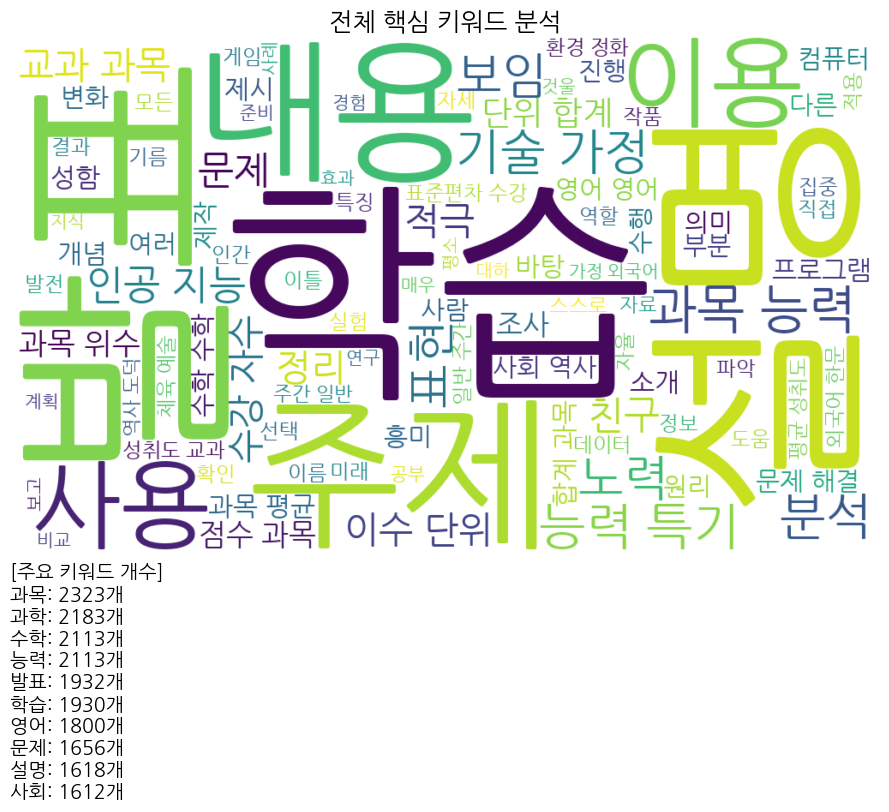

In [30]:
# 워드 클라우드 시각화
# 전체 워드 클라우드

all_words = ' '.join(analysis_df['명사 리스트'].str.replace(',', ' ').dropna())

wc = WordCloud(
    font_path=FONT_PATH,
    width=1000,
    height=600,
    background_color='white',
    max_words=100,
    prefer_horizontal=0.9
)
wordcloud = wc.generate(all_words)

# 키워드 데이터 추출
result = keyword_counts("전체 분석", all_words)
keywords_list = result['keywords']

# 캔버스와 GridSpec 설정
fig = plt.figure(figsize=(9, 8))
gs_main = GridSpec(1, 1, figure=fig)

# 중첩 GridSpec 생성(워드 클라우드와 텍스트가 겹치지 않도록 분리)
gs_nested = gs_main[0].subgridspec(10, 1, hspace=0.1)

ax_wc = fig.add_subplot(gs_nested[0:8, 0])  # 워드 클라우드 영역 (상단 80%)
ax_text = fig.add_subplot(gs_nested[8:10, 0]) # 텍스트 영역 (하단 20%)

# 워드 클라우드 시각화
ax_wc.imshow(wordcloud, interpolation='bilinear')
ax_wc.axis('off')
ax_wc.set_title("전체 핵심 키워드 분석", fontproperties=title_font_prop)

# 키워드 개수 출력
plot_keywords_on_axis(keywords_list, ax_text, title_font_prop, font_size=14)

plt.tight_layout()
plt.show()

### 2.3.2. 학과별 워드 클라우드

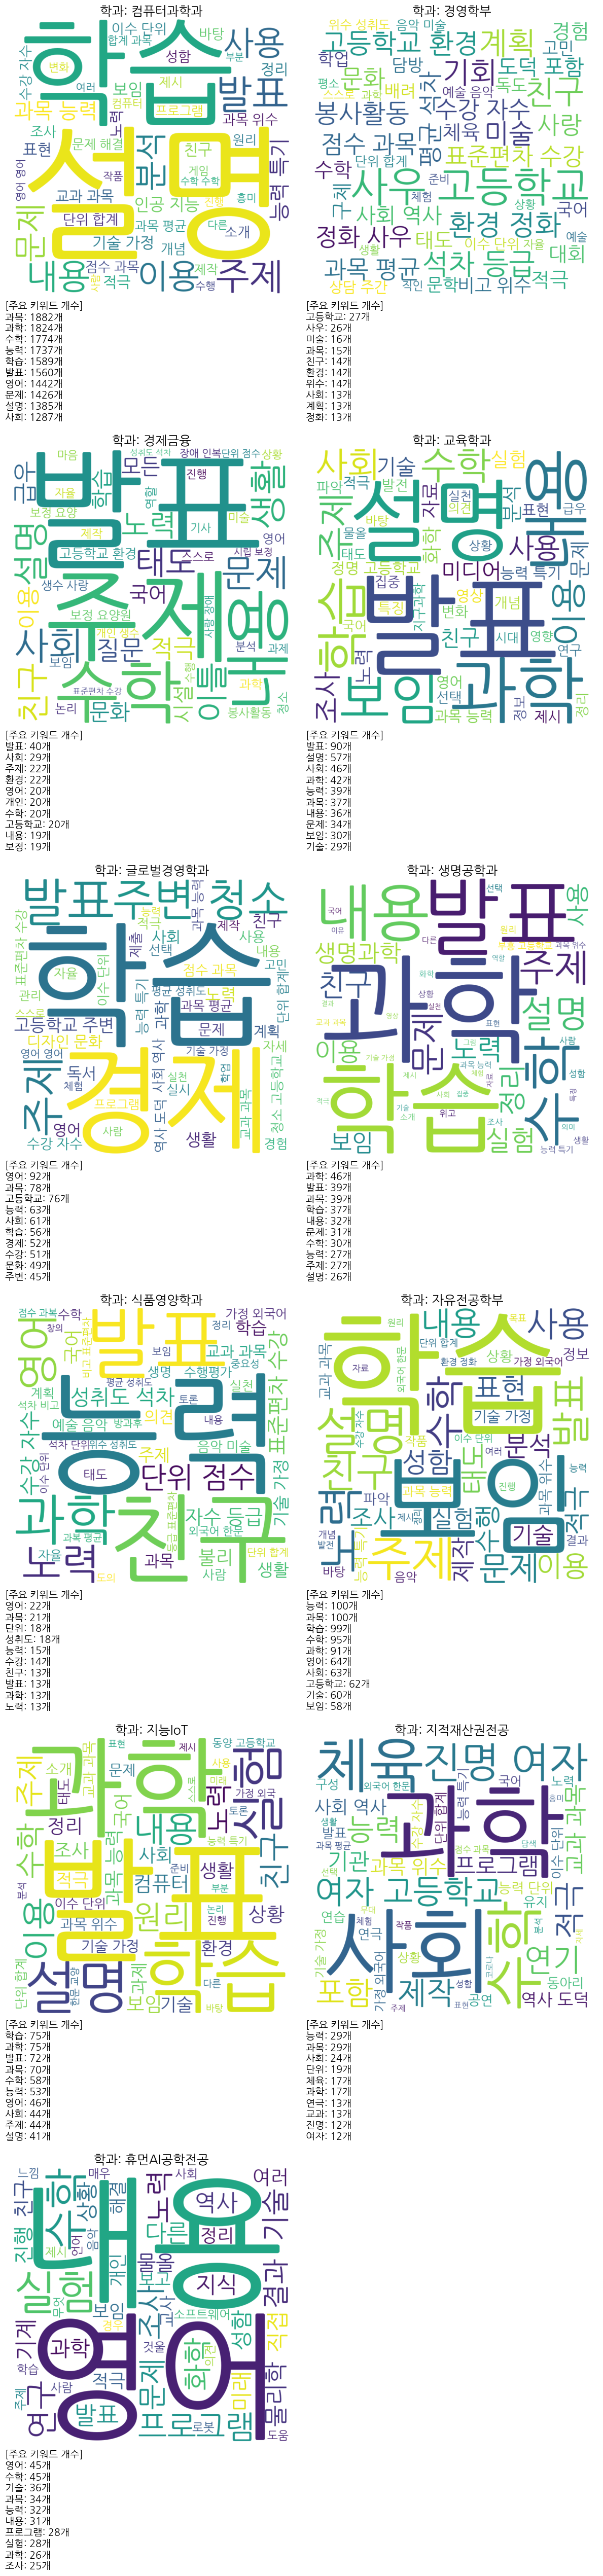

In [31]:
# 학과별 워드 클라우드
grouped_data = analysis_df.groupby('학과')['명사 리스트'].apply(
    lambda x: ' '.join(x.str.replace(',', ' ').dropna())
)

# 컴퓨터과학과가 가장 먼저 출력되도록 지정
TARGET_MAJOR = '컴퓨터과학과'
ordered_data = []

# 컴퓨터과학과 데이터 추출 및 맨 앞에 추가
if TARGET_MAJOR in grouped_data:
    ordered_data.append((TARGET_MAJOR, grouped_data[TARGET_MAJOR]))

    # 나머지 학과 데이터 추가
    remaining_items = [(major, text)
                       for major, text in grouped_data.items()
                       if major != TARGET_MAJOR]
    ordered_data.extend(remaining_items)
else:
    ordered_data = list(grouped_data.items())

num_groups = len(ordered_data)
MAX_COLS = 2 # 각 행에 캔버스 2개씩 출력

# 그룹화된 데이터가 있을 경우 시각화 진행
if num_groups > 0:
    # 총 필요한 행 수 계산
    nrows = math.ceil(num_groups / MAX_COLS)
    fig = plt.figure(figsize=(6 * MAX_COLS, 8.5 * nrows))

    # 메인 GridSpec 생성
    gs_main = GridSpec(nrows, MAX_COLS, figure=fig)

    # 워드 클라우드 생성
    # ordered_data 순회 (정해진 순서대로 순회)
    for i, (major, text) in enumerate(ordered_data):

        # 현재 학과가 들어갈 위치 계산
        row_idx = i // MAX_COLS
        col_idx = i % MAX_COLS

        # 해당 위치에 중첩 GridSpec 생성(워드클라우드와 텍스트가 겹치지 않도록 함)
        gs_nested = gs_main[row_idx, col_idx].subgridspec(10, 1, hspace=0.1)

        # 서브 영역 할당
        ax_wc = fig.add_subplot(gs_nested[0:8, 0])  # 워드 클라우드 영역 (상단 80%)
        ax_text = fig.add_subplot(gs_nested[8:10, 0]) # 키워드 텍스트 영역 (하단 20%)

        # 워드 클라우드 및 데이터 처리
        result = keyword_counts(major, text)
        keywords_list = result['keywords']

        wc_major = WordCloud(
            font_path=FONT_PATH,
            width=800,
            height=800,
            background_color='white',
            max_words=50
        )
        wordcloud_major = wc_major.generate(text)

        # 워드 클라우드 시각화
        ax_wc.imshow(wordcloud_major, interpolation='bilinear')
        ax_wc.axis('off')
        ax_wc.set_title(f"학과: {major}", fontproperties=title_font_prop)

        # 주요 키워드 개수 출력
        plot_keywords_on_axis(keywords_list, ax_text, title_font_prop, font_size=14)

    plt.tight_layout()
    plt.show()

else:
    print("\n학과별 그룹화할 데이터가 충분하지 않습니다.")

### 2.3.3. 전형별 워드 클라우드

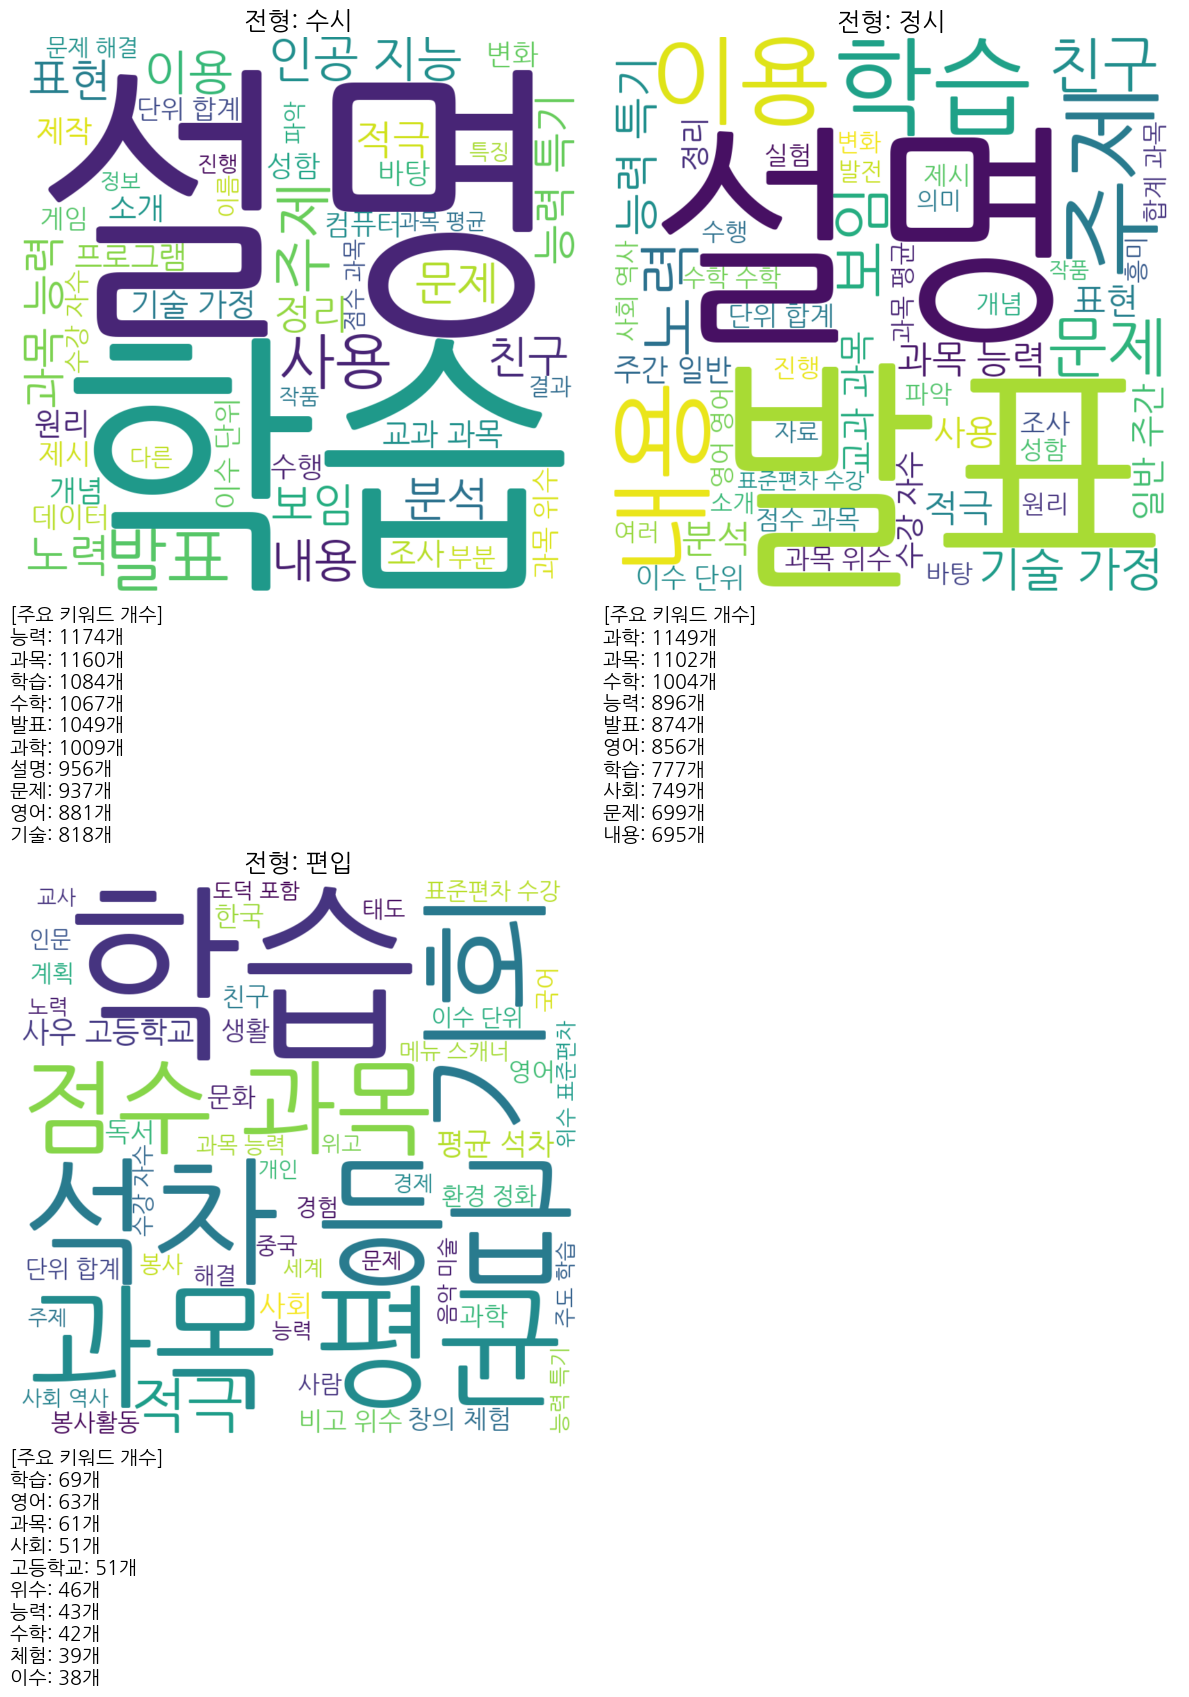

In [32]:
# 전형별 워드 클라우드
grouped_data2 = analysis_df.groupby('전형')['명사 리스트'].apply(
    lambda x: ' '.join(x.str.replace(',', ' ').dropna())
)
num_groups = len(grouped_data2)
MAX_COLS = 2 # 각 행에 캔버스 2개씩 출력

if num_groups > 0:

    # 총 필요한 행 수 계산
    nrows = math.ceil(num_groups / MAX_COLS)
    fig = plt.figure(figsize=(6 * MAX_COLS, 8.5 * nrows))

    # 메인 GridSpec 생성
    gs_main = GridSpec(nrows, MAX_COLS, figure=fig)

    # 전형별 워드 클라우드 생성
    for i, (type, text) in enumerate(grouped_data2.items()):

        # 현재 전형이 들어갈 위치 계산
        row_idx = i // MAX_COLS
        col_idx = i % MAX_COLS

        # 해당 위치에 중첩 GridSpec 생성
        gs_nested = gs_main[row_idx, col_idx].subgridspec(10, 1, hspace=0.1)

        # 서브 영역 할당
        ax_wc = fig.add_subplot(gs_nested[0:8, 0]) # 워드 클라우드 영역
        ax_text = fig.add_subplot(gs_nested[8:10, 0]) # 텍스트 영역

        # 워드 클라우드 및 데이터 처리
        result = keyword_counts(type, text)
        keywords_list = result['keywords']

        wc_type = WordCloud(
            font_path=FONT_PATH,
            width=800,
            height=800,
            background_color='white',
            max_words=50
        )
        wordcloud_type = wc_type.generate(text)

        # 워드 클라우드 시각화
        ax_wc.imshow(wordcloud_type, interpolation='bilinear')
        ax_wc.axis('off')
        ax_wc.set_title(f"전형: {type}", fontproperties=title_font_prop)

        # 주요 키워드 개수 출력
        plot_keywords_on_axis(keywords_list, ax_text, title_font_prop, font_size=14)

    plt.tight_layout()
    plt.show()

else:
    print("\n'전형'별 그룹화할 데이터가 충분하지 않습니다.")

# **3. 키워드 유사성 분포 분석(PCA)**   
*   유사한 키워드들이 이루는 군집을 분석함
*   TF-IDF를 이용해 키워드 중요도를 계산하고, 이를 이용하여 유사성을 판단함
*   그래프에서 두 점이 가까울수록 그 학생들은 키워드 유사성이 높다고 해석할 수 있음


## 3.1. 키워드 중요도 계산 및 PCA 수행

In [33]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

INPUT_CSV_FILE = 'keyword_processed_data.csv'
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'


# 한글 깨짐 방지 폰트 설정
font_name = fm.FontProperties(fname=FONT_PATH).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False
title_font_prop = fm.FontProperties(fname=FONT_PATH, size=16)

# 전처리 완료된 CSV 파일 로드
try:
    analysis_df = pd.read_csv(INPUT_CSV_FILE, encoding='utf-8-sig')
    analysis_df['명사 리스트'] = analysis_df['명사 리스트'].fillna('')
    analysis_df = analysis_df[analysis_df['명사 리스트'].str.strip().str.len() > 0].copy()
    N = len(analysis_df)
except FileNotFoundError:
    print(f"오류: '{INPUT_CSV_FILE}' 파일을 찾을 수 없습니다.")
    exit()

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer(max_features=300, token_pattern=r'\b\w+\b')
documents = analysis_df['명사 리스트'].str.replace(', ', ' ').tolist()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# PCA를 위해 희소 행렬을 밀집 행렬로 변환
tfidf_array = tfidf_matrix.toarray()
print(f"✅ TF-IDF 벡터 차원: {tfidf_array.shape}")

# PCA 수행
# 주성분 2개로 차원 축소
pca = PCA(n_components=2)

# PCA 모델 학습 및 데이터 변환
pca_results = pca.fit_transform(tfidf_array)

# PCA 결과를 DataFrame으로 정리
pca_df = pd.DataFrame(data=pca_results, columns=['Principal Component 1', 'Principal Component 2'])
# 학과 및 전형 정보 병합 (시각화 색상 구분 위해)
pca_df = pd.concat([pca_df, analysis_df[['학과', '전형']].reset_index(drop=True)], axis=1)

print(f"✅ PCA 완료. 총 분산 설명률: {pca.explained_variance_ratio_.sum()*100:.2f}%")

✅ TF-IDF 벡터 차원: (69, 300)
✅ PCA 완료. 총 분산 설명률: 28.26%


## 3.2. PCA 시각화

### 3.2.1. 학과별 키워드 유사성 분포

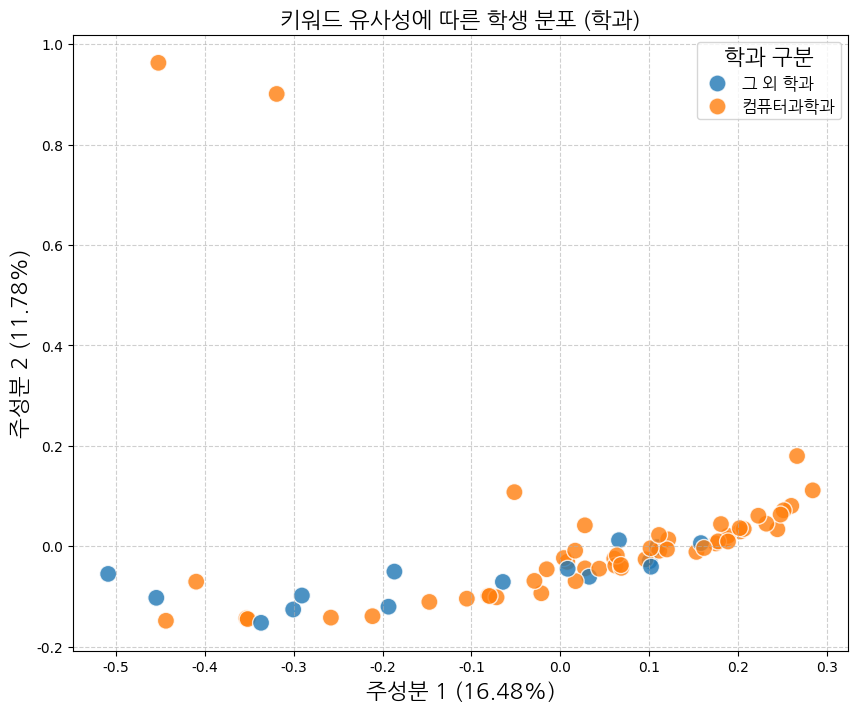

In [34]:
# 컴퓨터과학과와 그 외 학과를 구분함
pca_df['학과 구분'] = pca_df['학과'].apply(lambda x: '컴퓨터과학과' if x == '컴퓨터과학과' else '그 외 학과')

plt.figure(figsize=(10, 8))

# '학과 구분'을 기준으로 산점도 생성
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='학과 구분',
    data=pca_df,
    s=150,
    alpha=0.8
)

plt.title('키워드 유사성에 따른 학생 분포 (학과)', fontproperties=title_font_prop)
plt.xlabel(f'주성분 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontproperties=title_font_prop)
plt.ylabel(f'주성분 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontproperties=title_font_prop)

# 범례
legend = plt.legend(title='학과 구분', loc='best')
plt.setp(legend.get_title(), fontproperties=title_font_prop)
for text in legend.get_texts():
    text.set_font_properties(fm.FontProperties(fname=FONT_PATH, size=12))

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 3.2.2. 전형별 키워드 유사성 분포

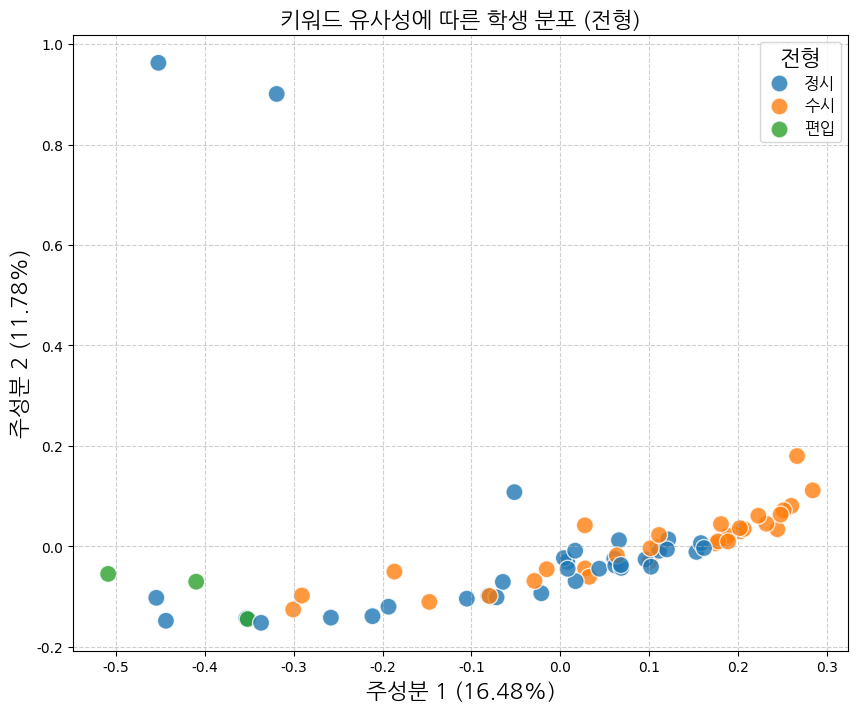

In [35]:
plt.figure(figsize=(10, 8))

# '전형'을 기준으로 산점도 생성
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='전형',
    data=pca_df,
    s=150,
    alpha=0.8
)

plt.title('키워드 유사성에 따른 학생 분포 (전형)', fontproperties=title_font_prop)
plt.xlabel(f'주성분 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontproperties=title_font_prop)
plt.ylabel(f'주성분 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontproperties=title_font_prop)

# 범례
legend = plt.legend(title='전형', loc='best')
plt.setp(legend.get_title(), fontproperties=title_font_prop)
for text in legend.get_texts():
    text.set_font_properties(fm.FontProperties(fname=FONT_PATH, size=12))

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 3.2.3. 학과 및 전형별 키워드 유사성 분포

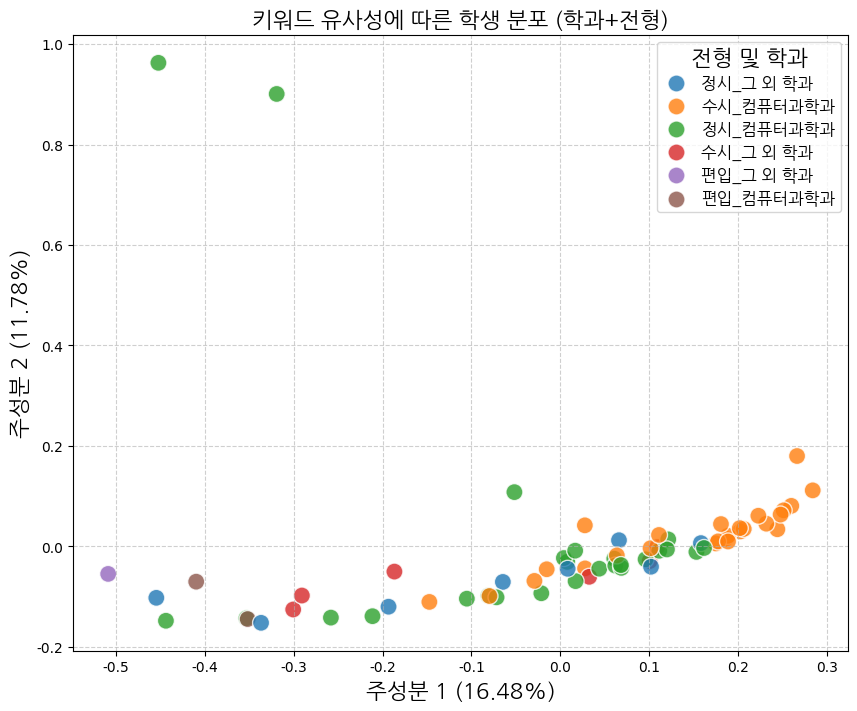

In [36]:
# 전형과 학과 구분을 결합한 새로운 컬럼 생성
pca_df['전형_학과'] = pca_df['전형'] + '_' + pca_df['학과 구분']

plt.figure(figsize=(10, 8))
# '전형_학과'를 기준으로 산점도 생성
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='전형_학과',
    data=pca_df,
    s=150,
    alpha=0.8
)

plt.title('키워드 유사성에 따른 학생 분포 (학과+전형)', fontproperties=title_font_prop)
plt.xlabel(f'주성분 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontproperties=title_font_prop)
plt.ylabel(f'주성분 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontproperties=title_font_prop)

# 범례
legend = plt.legend(title='전형 및 학과', loc='best')
plt.setp(legend.get_title(), fontproperties=title_font_prop)
for text in legend.get_texts():
    text.set_font_properties(fm.FontProperties(fname=FONT_PATH, size=12))

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()